Анастасия Панасюк 182

https://colab.research.google.com/drive/1YweXXCnry5y1p_RTL1uPDao6ZFMpKgKW?usp=sharing

In [130]:
import re
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, mean_absolute_error, mean_squared_error, max_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

In [3]:
!gdown --id 1aKsPwU3RgoAubx0TSn9_Y8avsgsIB6lx

Downloading...
From: https://drive.google.com/uc?id=1aKsPwU3RgoAubx0TSn9_Y8avsgsIB6lx
To: /content/Shoes_Data.csv
100% 1.31M/1.31M [00:00<00:00, 20.8MB/s]


In [4]:
df = pd.read_csv('Shoes_Data.csv')
df = df.drop_duplicates()  # удалю дупликаты - они есть

In [5]:
df.head()

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


In [1]:
# df.describe() 

In [ ]:
df['title'].value_counts().head(30)

Sparx Men's Running Shoes                                       7
Adidas Men Running Shoes                                        7
Red Tape Men's Formal Shoes                                     7
Clarks Men's Formal Shoes                                       5
LEONE Men Running Shoes                                         5
Hush Puppies Men Corso Loafer Formal Shoes                      4
Flavia Women Running Shoes                                      4
Lee Cooper Men's Formal Shoes                                   4
Hush Puppies Men Aaron Derby Formal Shoes                       3
Bata Men's Formal Shoes                                         3
LEONE Men's Running Shoes                                       3
Adidas Men's Adilette Shower Navy Blue Flip-Flops               3
Unistar Men's Running Shoes                                     3
Flavia Women's Running Shoes                                    3
ASICS Men's Running Shoes                                       3
Power Men'

Про некоторые кроссовки написано много отзывов

In [6]:
df['price'] = df.apply(lambda row: float(row.price.replace('₹', '')), axis=1)

In [7]:
df['rating'] = df.apply(lambda row: float(row.rating.replace(' out of 5 stars', '')), axis=1)

Посмотрим топ кроссовок для инсайтов, как выглядят данные. Видим ин. языки.

In [8]:
df.sort_values(by=['price'], ascending=False).head(10)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
847,Saucony Men's Canyon Tr Trail Running Shoe,7992.0,4.4,22 ratings,For those looking to add variety to their work...,Well cushioned trail shoes|| Verified Purchase...,5.0 out of 5 stars|| 4.0 out of 5 stars|| 4.0 ...,Men
1192,Converse Unisex-Adult Sneakers,7702.0,1.0,1 rating,Converse is Change. We started on the court an...,Colour is not good,1.0 out of 5 stars,Women
832,Nike Men's Cortez Basic Premium Iron Grey/Whit...,7621.0,4.6,55 ratings,STEP INTO A BOLD NEW WORLD : Inspired by Bill ...,Verified Purchase|| Verified Purchase|| Verifi...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
1196,Nike Women's WMNS Air Zoom Pegasus 37 Running ...,7480.0,4.5,67 ratings,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...,Verified Purchase|| Verified Purchase|| Verifi...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 ...,Women
1193,Nike Men's React Vision Running Shoes,7256.0,4.4,200 ratings,The Nike react vision is a STORY of surreal co...,Must buy|| not have a great fiting but great q...,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Women
827,Nike Men's Air Zoom Pegasus 38 Running Shoe,7096.0,4.0,51 ratings,Your workhorse with wings returns.The Nike Air...,PERFECT RUNNING SHOES AS DESCRIBED BY NIKE|| M...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
828,ASICS Unisex-Adult Gelburst 24 Ge Basketball Shoe,7039.0,4.3,12 ratings,-,Verified Purchase|| Verified Purchase,1.0 out of 5 stars|| 4.0 out of 5 stars,Men
831,ASICS Men's Evoride 2 Platform,6999.0,4.8,25 ratings,Whether it's tempo runs long runs or racing th...,Report abuse|| Report abuse|| Report abuse|| R...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
839,Adidas Men's APAC Halo M Tennis Shoe,6999.0,3.8,7 ratings,BB Fit: These men's adidas tennis shoes back y...,Verified Purchase,3.0 out of 5 stars,Men
826,Puma Cell Fraction Fade Men's Running Shoes,6999.0,4.2,16 ratings,PRODUCT STORY Stride out in pure comfort and s...,I am no satisfied with this product|| Nice pro...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 ...,Men


Давайте все почистим

In [9]:
def normalize(line):
  line = re.sub('_', ' ', line)
  return re.sub(' +', ' ', line)

def delete_non_latin(line):
  if not re.search('\w+', line):
    return None
  if not re.findall('[^A-z0-9]+[^\w]', line):
    return line
  else:
    sentences = re.split('_+', line)
    latin = []
    for sentence in sentences:
      if len(re.findall('[A-z]+ ', sentence))/len(sentence.split(' ')) > 0.5:
        latin.append(normalize(sentence))
    latin = ' '.join(latin).strip(' ')
    return latin

In [12]:
df['product_description'] = [delete_non_latin(row) for row in df['product_description']]
df = df.dropna()

### Задание 1 (предсказать цену по описанию: регрессия)

Возьмем только нужное для первого задания: цену и описание

In [13]:
task1 = df[['price', 'product_description']]
pd.set_option('display.max_colwidth', None)
task1.sort_values('price', ascending=False)

,price,product_description
847,7992.0,For those looking to add variety to their workout routine the Canyon TR lets them cross over from road to trail with dirt-friendly traction that still rides smooth on the road.
1192,7702.0,Converse is Change. We started on the court and got adopted on the street. We began as a rubber company to make sneakers and boots and then we found basketball and reinvented the sport. The Converse Chuck Taylor All Star sneaker became the court sneaker it stood for the game. From there we moved into other sports with new sneaker silhouettes like the Pro Leather the Star Player and the Weapon. The Star Chevron showed up and became another Converse symbol. And just when we seemed to be destined for athletes only  something happened.
832,7621.0,STEP INTO A BOLD NEW WORLD : Inspired by Bill Bowerman's first masterpiece the Nike Cortez Basic Premium pays homage to the iconic running shoe as it celebrates the Earth with a medley of recycled materials. The reclaimed canvas and Flyleather upper made with at least 50% recycled leather fiber and combined with synthetic materials has a richly textured appearance while the classic foam midsole keeps the iconic look you love with its wedge of super-soft Crater foam. This product is made with at least 20% recycled materials by weight.
1196,7480.0,The Nike women's running shoe feels and even looks soft and plush. Yet it provides incredible support to help you run your best from your first 5K to your latest marathon and delivers an ultra-responsive feel with each stride.
1193,7256.0,The Nike react vision is a STORY of surreal comfort. Layered textures shapes and vivid colours are combined in a design influenced by the exaggerated world of our dreams while react foam and an ultra-plush tongue provide surreal comfort.
...,...,...
47,155.0,Light weight rubber sole for excellent grip. Sparx presents footwear range that will keep your feet at great ease While you walk run or work out in the Gym. These are light in weight Flexible and very comfortable to wear as well.
871,142.0,This trendy paragon flip flop slipper for women is comfortable and sports a v-strap for a firm grip. The durable casual footwear is perfect for the modern woman and is available in 2 colors: new blue and pink.
21,132.0,A part of paragon's paralite range of footwear paralite 1140 are stylish flip-flops for men with thong straps and a light heel. The flip-flops are long-lasting and comfortable. They come in two color options - black body with a red line along the heel or navy blue body with an orange line along the heel.
56,129.0,Sparx Presents footwear range that Will Keep Your Feet At Great Ease While You walk run or work out in the Gym. These Are Light In Weight Flexible And Very Comfortable To Wear As Well.


#### Фича инжиниринг и мысли

Гипотеза, что супер дорогие бренды могут себе позволить использовать капс, обозначая этим какой-то КОНЦЕПТ (STEP INTO A BOLD NEW WORLD : Inspired by Bill Bowerman's first masterpiece the Nike Cortez Basic Premium pays homage to the iconic running shoe as it celebrates the Earth with a medley of recycled materials...
1193	7256.0	The Nike react vision is a STORY)

In [14]:
def count_concept(line):
  return len(re.findall('[^\w]?[A-Z][A-Z]+[^\w]', line))

In [15]:
task1['concepts'] = [count_concept(row) for row in task1['product_description']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


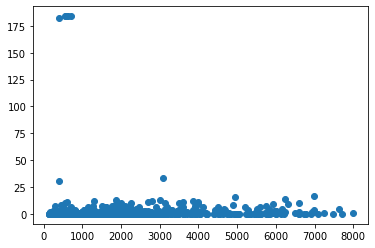

In [18]:
plt.scatter(task1['price'], task1['concepts'])
plt.show()

In [19]:
task1[task1['concepts'] >= 25].sort_values('price', ascending=False)

,price,product_description,concepts
718,3079.0,MEDIAL BRANDING: 3 STRIPES ON QUARTER FXG OUTSOLE: Flexible ground outsole to move with high-speed control and stability on firm ground (dry natural grass) artificial grass (long-bladed synthetic fibre) and hard ground Synthetic Upper: SOFT UPPER WITH DECO STITCHING FOR ADDED VALUE LACED: U-THROAT COLLAR CONSTRUCTIONS ALLOWS FOR EASE OF ENTRY FOR ALL FOOT TYPES. LACES PROVIDE LOCK DOWN. BB Fit: Fine-tune your instincts in these versatile football boots. Their soft synthetic upper allows for easy entry and keeps you comfortable on the pitch. The outsole ensures you stay a class apart on firm ground artificial grass and hard ground.,33
271,709.0,CENTRINO CASUAL SHOES MATERIAL: SYNTHETIC MATERIAL. THESE SHOES ARE MADE UP OF HIGH QUALITY SYNTHETIC MATERIAL STAYS STRONG AND DURABLE - MEANING THE SHOES WILL LAST MUCH LONGER. LIFESTYLE: FORMAL / BUSINESS. PAIR THESE STYLISH CENTRINO SHOES WITH YOUR SHIRT & TROUSERS FOR THAT PERFECT LOOK. OFFICE WEAR OFFICE SHOES FORMAL SHOES SLIP-ON BUSINESS SHOES. CLOSURE: SLIP-ON. CENTRINO SHOES ARE HAND-CRAFTED FOR THAT PERFECT FIT. PERFORATED INSOLE LETS AIR PASS THROUGH THE MATERIAL. THIS IS GREAT FOR LEATHER SHOES BECAUSE THE MATERIAL LETS AIR IN TO COOL YOUR FEET AND STOP THEM FROM SMELLING. FIT: COMFORT FIT. CENTRINO ENDORSES STYLE THAT STRIKES A FINE BALANCE BETWEEN THE CLASSIC AND THE MODERN THE DISCREET AND THE BOLD WITH GOOD TASTE BEING THE ONLY CRITERION FOR SELECTION. CARE INSTRUCTIONS: ALLOW YOUR PAIR OF SHOES TO AIR ON A REGULAR BASIS. THIS HELPS THEM RETAIN THEIR NATURAL SHAPE DRY SHOES AT ROOM TEMPERATURE ONLY. EXCESSIVE EXPOSURE TO SUN WILL CAUSE THE LEATHER TO SHRINK WRINKLE HARDEN DRY AND CRACK. USE SHOE BAGS TO PREVENT ANY STAINS OR MILDEW DUST ANY DRY DIRT FROM THE SURFACE USING A CLEAN CLOTH. FOR MENS,184
242,623.0,CENTRINO LOAFER SHOES MATERIAL: SYNTHETIC MATERIAL. THESE SHOES ARE MADE UP OF HIGH QUALITY SYNTHETIC MATERIAL STAYS STRONG AND DURABLE - MEANING THE SHOES WILL LAST MUCH LONGER. LIFESTYLE: FORMAL / BUSINESS. PAIR THESE STYLISH CENTRINO SHOES WITH YOUR SHIRT & TROUSERS FOR THAT PERFECT LOOK. OFFICE WEAR OFFICE SHOES FORMAL SHOES SLIP-ON BUSINESS SHOES. CLOSURE: SLIP-ON. CENTRINO SHOES ARE HAND-CRAFTED FOR THAT PERFECT FIT. PERFORATED INSOLE LETS AIR PASS THROUGH THE MATERIAL. THIS IS GREAT FOR LEATHER SHOES BECAUSE THE MATERIAL LETS AIR IN TO COOL YOUR FEET AND STOP THEM FROM SMELLING. FIT: COMFORT FIT. CENTRINO ENDORSES STYLE THAT STRIKES A FINE BALANCE BETWEEN THE CLASSIC AND THE MODERN THE DISCREET AND THE BOLD WITH GOOD TASTE BEING THE ONLY CRITERION FOR SELECTION. CARE INSTRUCTIONS: ALLOW YOUR PAIR OF SHOES TO AIR ON A REGULAR BASIS. THIS HELPS THEM RETAIN THEIR NATURAL SHAPE DRY SHOES AT ROOM TEMPERATURE ONLY. EXCESSIVE EXPOSURE TO SUN WILL CAUSE THE LEATHER TO SHRINK WRINKLE HARDEN DRY AND CRACK. USE SHOE BAGS TO PREVENT ANY STAINS OR MILDEW DUST ANY DRY DIRT FROM THE SURFACE USING A CLEAN CLOTH. FOR MENS,184
165,575.0,CENTRINO CASUAL SHOES MATERIAL: SYNTHETIC MATERIAL. THESE SHOES ARE MADE UP OF HIGH QUALITY SYNTHETIC MATERIAL STAYS STRONG AND DURABLE - MEANING THE SHOES WILL LAST MUCH LONGER. LIFESTYLE: FORMAL / BUSINESS. PAIR THESE STYLISH CENTRINO SHOES WITH YOUR SHIRT & TROUSERS FOR THAT PERFECT LOOK. OFFICE WEAR OFFICE SHOES FORMAL SHOES SLIP-ON BUSINESS SHOES. CLOSURE: SLIP-ON. CENTRINO SHOES ARE HAND-CRAFTED FOR THAT PERFECT FIT. PERFORATED INSOLE LETS AIR PASS THROUGH THE MATERIAL. THIS IS GREAT FOR LEATHER SHOES BECAUSE THE MATERIAL LETS AIR IN TO COOL YOUR FEET AND STOP THEM FROM SMELLING. FIT: COMFORT FIT. CENTRINO ENDORSES STYLE THAT STRIKES A FINE BALANCE BETWEEN THE CLASSIC AND THE MODERN THE DISCREET AND THE BOLD WITH GOOD TASTE BEING THE ONLY CRITERION FOR SELECTION. CARE INSTRUCTIONS: ALLOW YOUR PAIR OF SHOES TO AIR ON A REGULAR BASIS. THIS HELPS THEM RETAIN THEIR NATURAL SHAPE DRY SHOES AT ROOM TEMPERATURE ONLY. EXCESSIVE EXPOSURE TO SUN WILL CAUSE THE LEATHER TO SHRINK WRINKLE HARDEN DRY AND C

Видим аутлаеры, в которых все написано капсом. Значит, если все капсом, то это ничего не значит и надо перевести в lower регистр

Еще *: интересно, одинаковые ли слова капсят

Давайте посмотрим, поможет ли нам, если мы постараемся выделить ner - свидетельствует ли о чем-то неймдроппинг. Конечно, ner не всегда хорошо работает... особенно нлткшный, но все равно


In [24]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def find_ner(line):
  count = 0
  for sent in nltk.sent_tokenize(line):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
       if hasattr(chunk, 'label'):
          count += 1
  return count

task1['ner'] = [find_ner(row) for row in task1['product_description']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


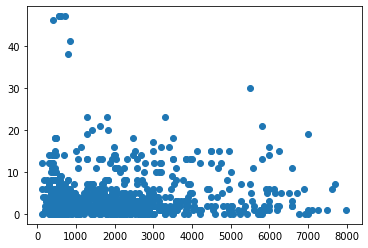

In [ ]:
plt.scatter(task1['price'], task1['ner'])
plt.show()

In [ ]:
task1[task1['ner'] >= 30].sort_values('price', ascending=False)

,price,product_description,concepts,ner
777,5499.0,Keep your options super flexible and comfortable with suave style in the SKECHERS Moreway - Chapson shoe. Soft woven mesh fabric and smooth synthetic upper in a slip on casual comfort loafer styled boat shoe with stitching and overlay accents. Air Cooled Memory Foam insole. Construction Soft smooth woven mesh fabric upper Smooth synthetic overlays at collar and heel Slip on casual comfort loafer moc boat shoe design Stitching accents Stitched raised seam accented moc toe front Breathable mesh fabric with smooth solid look Tone-on-tone synthetic overlays at collar and heel panel Smooth refined loafer design with plain Venetian front and rolled stitch detailing at sides Heel panel overlay with stitched edging Slip on design with flexible comfort instep panel Padded collar Soft fabric shoe lining Air Cooled Memory Foam cushioned comfort insole Goga Mat Arch cushion for added support Very lightweight shock absorbing midsole with articulated design Flexible siped traction outsole 1 inch heel Keep your options super flexible and comfortable with suave style in the SKECHERS Moreway - Chapson shoe. Soft woven mesh fabric and smooth synthetic upper in a slip on casual comfort loafer styled boat shoe with stitching and overlay accents. Air Cooled Memory Foam insole. Construction Soft smooth woven mesh fabric upper Smooth synthetic overlays at collar and heel Slip on casual comfort loafer moc boat shoe design Stitching accents Stitched raised seam accented moc toe front Breathable mesh fabric with smooth solid look Tone-on-tone synthetic overlays at collar and heel panel Smooth refined loafer design with plain Venetian front and rolled stitch detailing at sides Heel panel overlay with stitched edging Slip on design with flexible comfort instep panel Padded collar Soft fabric shoe lining Air Cooled Memory Foam cushioned comfort insole Goga Mat Arch cushion for added support Very lightweight shock absorbing midsole with articulated design Flexible siped traction outsole 1 inch heel,2,30
254,848.9,Continual attention to innovation is one of Lotto's main strengths. Technology product design and Italian style are absolute requirements for Lotto's high performance sports clothing and footwear and also for leisure clothing and footwear. Italian style and technological innovation within the heart of sport. Born from the last part of the name of its founders the brand name Lotto is now synonymous in the sports world with technological research and design innovation. The accompanying double lozenge figure representing two partially overlapping playing fields is a clear sign of company policy committed from the beginning to soccer and tennis and of an innate inclination towards active sport. The Lotto logo was created in 1973. Since then very few and only slight graphic variations have been made thereby ensuring continuity of the brand image and maximum recognisability over the years. Lotto today distributes its products in about 100 countries through independent sports article stores specialised chain-stores and large stores with specialised sports departments. Continual attention to innovation is one of Lotto's main strengths. Technology product design and Italian style are absolute requirements for Lotto's high performance sports clothing and footwear and also for leisure clothing and footwear. Italian style and technological innovation within the heart of sport. In Lotto’s history major sponsorships have always been the keystones to success stories. This tradition continues today in football with World Cup winner Luca Toni Joan Capdevila Andrea Ranocchia and Federico Balzaretti. It also forges ahead with teams ranging from Genoa in Italy Borussia Mönchengladbach in Germany Sochaux in France Queens Park Rangers in the UK El Deportivo La Coruna in Spain Goias and Recife in Brazil San Lorenzo de Almagro in Argentina as well as the national teams of Costa Rica and Panama. In tennis Lotto has been p

Цена VS длина описания

In [ ]:
task1['length'] = [len(row.split(' ')) for row in task1['product_description']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


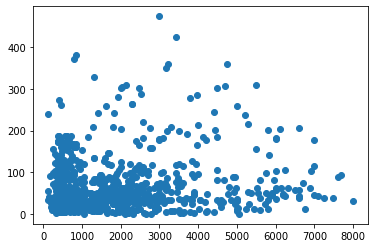

In [ ]:
plt.scatter(task1['price'], task1['length'])
plt.show()

In [ ]:
task1[task1['length'] >= 300].sort_values('price', ascending=False)

,price,product_description,concepts,ner,length
777,5499.0,Keep your options super flexible and comfortable with suave style in the SKECHERS Moreway - Chapson shoe. Soft woven mesh fabric and smooth synthetic upper in a slip on casual comfort loafer styled boat shoe with stitching and overlay accents. Air Cooled Memory Foam insole. Construction Soft smooth woven mesh fabric upper Smooth synthetic overlays at collar and heel Slip on casual comfort loafer moc boat shoe design Stitching accents Stitched raised seam accented moc toe front Breathable mesh fabric with smooth solid look Tone-on-tone synthetic overlays at collar and heel panel Smooth refined loafer design with plain Venetian front and rolled stitch detailing at sides Heel panel overlay with stitched edging Slip on design with flexible comfort instep panel Padded collar Soft fabric shoe lining Air Cooled Memory Foam cushioned comfort insole Goga Mat Arch cushion for added support Very lightweight shock absorbing midsole with articulated design Flexible siped traction outsole 1 inch heel Keep your options super flexible and comfortable with suave style in the SKECHERS Moreway - Chapson shoe. Soft woven mesh fabric and smooth synthetic upper in a slip on casual comfort loafer styled boat shoe with stitching and overlay accents. Air Cooled Memory Foam insole. Construction Soft smooth woven mesh fabric upper Smooth synthetic overlays at collar and heel Slip on casual comfort loafer moc boat shoe design Stitching accents Stitched raised seam accented moc toe front Breathable mesh fabric with smooth solid look Tone-on-tone synthetic overlays at collar and heel panel Smooth refined loafer design with plain Venetian front and rolled stitch detailing at sides Heel panel overlay with stitched edging Slip on design with flexible comfort instep panel Padded collar Soft fabric shoe lining Air Cooled Memory Foam cushioned comfort insole Goga Mat Arch cushion for added support Very lightweight shock absorbing midsole with articulated design Flexible siped traction outsole 1 inch heel,2,30,310
1168,4749.0,Designed for race day or fast training the Wave Sayonara delivers an exceptional ride in light weight versatile execution. It features a harmonious mid-foot wrap for refined fit an ultra-responsive U4iC midsole and parallel wave in the heel for a cushioned run and a wide fore foot and full ground midsole for stable fast ride. Pronation type provided is performance neutral which is built with lower profile midsole dimensions for a more responsive performance ride and allows the foot to work without impediments. Rihachi Mizuno opened his first store in 1906 to share his passion for sports through the gear he and a small team of craftsmen proudly made in Japan. Driven by an uncompromising focus on athletic performance and aware that getting small product design details right could make a big difference on the field every generation of Mizuno products since then has combined meticulous craftsmanship with restless innovation. Today Mizuno Sports extends this legacy of innovation by combining time-honored heritage with a modern sense of style for items that fit your life the way you want to live it. Mizuno not only supports sporting activities by offering better sporting goods but also develops products and services that make the most of the value of sports and actively spread that in daily life. Rihachi Mizuno opened his first store in 1906 to share his passion for sports through the gear he and a small team of craftsmen proudly made in japan driven by an uncompromising focus on athletic performance and aware that getting small product design details right could make a big difference on the field every generation of Mizuno products since then has combined meticulous craftsmanship with restless innovation today Mizuno sports extends this legacy of innovation by combining time-honoured heritage with a modern sense of style for items that fit your life the way you want to live it mizuno not o

Длинные предложения в целом у более дорогих кроссовок, но это скорее выбросы.

Вывод, что супер дорогие туфли скорее выверены по описаниям и там нет слишком большого количества NER


Добавлю препроцессинг, что тексты, в которых все капсом, будут переведын в нижний регистр
Также в случае, Если Все Слова Текста набраны с большой буквы, оставлю первые слова предложений с большой, а остальные слова переведу в нижний регистр

Почищу датафрейм и потом пересчитаю все метрики (ner, concepts, length)

In [20]:
task1 = df[['price', 'product_description']]

In [21]:
def lower_if_all(line):
  if not re.search('[a-z]', line):
    return line.lower()
  elif len(re.findall('[^\w]?[A-Z][a-z]+[^\w]', line))/len(line.split(' ')) > 0.9:
    sentences = line.split('.')
    other = []
    for sentence in sentences:
      tokens = sentence.split(' ')
      other.append(tokens[0] + ' ' + ' '.join([token.lower() for token in tokens[1:]]))
    return '.'.join(other)
  return line

In [22]:
task1['product_description'] = [lower_if_all(row) for row in task1['product_description']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
task1['length'] = [len(row.split(' ')) for row in task1['product_description']]
task1['length'] = task1['length']/task1['length'].median() # делю длину на медиану, чтобы посмотреть, в целом длиннее текст или короче чем обычно в выборке
task1['concepts'] = [count_concept(row)/len(row.split(' ')) for row in task1['product_description']]
task1['ner'] = [find_ner(row)/len(row.split(' ')) for row in task1['product_description']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
task1.head(10)

,price,product_description,length,concepts,ner
0,279.0,Elevate your style with this classy pair of Running Shoe from the house of CLYMB brand. Featuring a contemporary refined design with exceptional comfort this pair is perfect to give your quintessential dressing an upgrade.,35,0.028571,0.028571
1,479.0,The product will be an excellent pick for you. It ensures an easy maintenance.,14,0.000000,0.000000
2,430.0,Flaunt with these stylish and unique red casual shoes as per the latest fashion trend from the house of T-Rock Brand known for its wide range of men's casual formal sports/running ethnic party wear shoes. This pair is having classic style which will add glamour to your look. These shoes go well with your casual wear. Team it with your casual attire to complete your perfect casual or party look.,70,0.000000,0.014286
3,499.0,Robbie jones shoes are designed to keeping in mind durability as well as trends the most stylish range of shoes. they are exclusively designed to match the latest trends of the new generation. this pair of shoes is sure to make you look smart & classy. these will go with most of your casual outfits. this product is made of premium quality and highly material. wearing this prime quality amazing and cozy shoe with the combination of jean and t-shirt. it presents standard look to your personality. we are always providing latest fashion shoes for men's casual shoes for men.,101,0.000000,0.009901
4,499.0,Sparx is a spectacular range of footwear from the house of Relaxo Footwears Ltd. a name trusted among millions of people in India and across the world for delivering unmatched quality. Since its inception the company has established a benchmark for bringing the finest range of footwears. Sparx the most stylish range of shoes sandals and slippers are exclusively designed to match the latest trends of the new generation. Known for its sturdy and stylish designs Sparx is an iconic youth brand for those who dare to explore the world. Sparx is a spectacular range of footwear from the house of Relaxo Footwears Ltd. a name trusted among millions of people in India and across the world for delivering unmatched quality. Since its inception the company has established a benchmark for bringing the finest range of footwears. A perfect combination of comfort style and workmanship Sparx is all about confidence and making a fashion statement. Its flaunting design pattern sparks a cool statement as you take a step ahead in them.,171,0.000000,0.046784
5,449.0,casual shoes for boys and mens in white colour,9,0.000000,0.000000
6,499.0,Robbie Jones has a vast collection of casual shoes for men. You can explore our range of casual shoes daily shoes or lifestyle shoes.Take your pick from an array of sports shoes in vibrant colours like red yellow green blue brown black grey olive pink beige and white. Designed for top performance these shoes match the way you play or run. Available in materials like leather canvas suede leather faux leather mesh etc these shoes are lightweight comfortable sturdy and extremely sporty. The sole of all Robbie Jones shoes is designed to provide an increased amount of comfort and the material is good enough to provide an improved fit. These shoes are easy to maintain and last for a really long time given to their durability.,126,0.000000,0.023810
7,449.0,Elevate your style with this classy pair of Loafer from the house of KNOOS brand. Featuring a contemporary refined design with exceptional comfort this pair is perfect to give your quintessential dressing an upgrade.,34,0.029412,0.058824
8,559.0,Very stylish and comfortable shoes.,5,0.000000,0.000000
9,399.0,Elevate your style with this classy pair of Sneaker from the house of ROAD RUNNER brand. Featuring a contemporary refined design with exceptional comfort this pair is perfect to give your quintessential dressing an upgrade.,35,0.057143,0.057143


### Предобработка

Удаляю все стоп-слова, лемматизирую. Если в тексте встречается слово капсом, в матрицу пойдет два слова: слово-капсом и слово-без-капса. Я считаю, что "капс" - это упоминание какого-то концепта, на котором концентрируется автор текста и который хочет выделить, поэтому это важно.

In [27]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[\w-]+')

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
stops = set(stopwords.words('english'))

def lemmatize(line):
  tokens = tokenizer.tokenize(line)
  lemmas = []
  for token, tag in pos_tag(tokens):
      if len(token) > 1:
        lemma = lemmatizer.lemmatize(token.lower(), tag_map[tag[0]])
        if lemma not in stops:
          if not re.search('[a-z]', token):
            lemmas.append(f'{lemma.upper()} {lemma}')
          else:
            lemmas.append(lemma)
  return ' '.join(lemmas)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [28]:
task1['lemmatized'] = [lemmatize(row) for row in task1['product_description']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
task1.head(10)

,price,product_description,length,concepts,ner,lemmatized
0,279.0,Elevate your style with this classy pair of Running Shoe from the house of CLYMB brand. Featuring a contemporary refined design with exceptional comfort this pair is perfect to give your quintessential dressing an upgrade.,35,0.028571,0.028571,elevate style classy pair run shoe house CLYMB clymb brand feature contemporary refine design exceptional comfort pair perfect give quintessential dress upgrade
1,479.0,The product will be an excellent pick for you. It ensures an easy maintenance.,14,0.000000,0.000000,product excellent pick ensure easy maintenance
2,430.0,Flaunt with these stylish and unique red casual shoes as per the latest fashion trend from the house of T-Rock Brand known for its wide range of men's casual formal sports/running ethnic party wear shoes. This pair is having classic style which will add glamour to your look. These shoes go well with your casual wear. Team it with your casual attire to complete your perfect casual or party look.,70,0.000000,0.014286,flaunt stylish unique red casual shoe per late fashion trend house t-rock brand know wide range men casual formal sport run ethnic party wear shoe pair classic style add glamour look shoe go well casual wear team casual attire complete perfect casual party look
3,499.0,Robbie jones shoes are designed to keeping in mind durability as well as trends the most stylish range of shoes. they are exclusively designed to match the latest trends of the new generation. this pair of shoes is sure to make you look smart & classy. these will go with most of your casual outfits. this product is made of premium quality and highly material. wearing this prime quality amazing and cozy shoe with the combination of jean and t-shirt. it presents standard look to your personality. we are always providing latest fashion shoes for men's casual shoes for men.,101,0.000000,0.009901,robbie jones shoe design keep mind durability well trend stylish range shoe exclusively design match late trend new generation pair shoe sure make look smart classy go casual outfit product make premium quality highly material wear prime quality amazing cozy shoe combination jean t-shirt present standard look personality always provide late fashion shoe men casual shoe men
4,499.0,Sparx is a spectacular range of footwear from the house of Relaxo Footwears Ltd. a name trusted among millions of people in India and across the world for delivering unmatched quality. Since its inception the company has established a benchmark for bringing the finest range of footwears. Sparx the most stylish range of shoes sandals and slippers are exclusively designed to match the latest trends of the new generation. Known for its sturdy and stylish designs Sparx is an iconic youth brand for those who dare to explore the world. Sparx is a spectacular range of footwear from the house of Relaxo Footwears Ltd. a name trusted among millions of people in India and across the world for delivering unmatched quality. Since its inception the company has established a benchmark for bringing the finest range of footwears. A perfect combination of comfort style and workmanship Sparx is all about confidence and making a fashion statement. Its flaunting design pattern sparks a cool statement as you take a step ahead in them.,171,0.000000,0.046784,sparx spectacular range footwear house relaxo footwear ltd name trust among million people india across world deliver unmatched quality since inception company establish benchmark bring fine range footwear sparx stylish range shoe sandal slipper exclusively design match late trend new generation known sturdy stylish design sparx iconic youth brand dare explore world sparx spectacular range footwear house relaxo footwear ltd name trust among million people india across world deliver unmatched quality since inception company establish benchmark bring fine range footwear perfect combination comfort style workmanship sparx confidence make 

### Векторизовать

In [31]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word')
bow_vectorizer = CountVectorizer()
X_tf = tfidf_vectorizer.fit_transform(task1['lemmatized'])
X_bow = bow_vectorizer.fit_transform(task1['lemmatized'])

Давайте посмотрим какая точность просто на tfidf / bow без доп. фичей

In [62]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, task1['price'], test_size=0.70, random_state=42)

model = linear_model.LinearRegression()
model = model.fit(X_train_bow, y_train_bow)
train_preds = model.predict(X_train_bow)
test_preds = model.predict(X_test_bow)

print('result on train: {}'.format(mean_absolute_error(y_train_bow, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_bow,test_preds)))

result on train: 112.30269558622469
result on test: 1676.914245847357


In [63]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, task1['price'], test_size=0.70, random_state=42)

model = linear_model.LinearRegression()
model = model.fit(X_train_tf, y_train_tf)
train_preds = model.predict(X_train_tf)
test_preds = model.predict(X_test_tf)

print('result on train: {}'.format(mean_absolute_error(y_train_tf, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_tf,test_preds)))

result on train: 110.30176734281122
result on test: 1364.5627172348125


In [66]:
regr = RandomForestRegressor(random_state=42)
regr.fit(X_train_bow, y_train_bow)
train_preds = regr.predict(X_train_bow)
test_preds = regr.predict(X_test_bow)

print('result on train: {}'.format(mean_absolute_error(y_train_bow, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_bow,test_preds)))

result on train: 368.9992296540093
result on test: 811.851672456207


In [64]:
regr = RandomForestRegressor(random_state=42)
regr.fit(X_train_tf, y_train_tf)
train_preds = regr.predict(X_train_tf)
test_preds = regr.predict(X_test_tf)

print('result on train: {}'.format(mean_absolute_error(y_train_tf, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_tf, test_preds)))


result on train: 377.64124561741886
result on test: 817.0923138100343


In [74]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)

regr = make_pipeline(StandardScaler(with_mean=False), SVR(C=1.0, epsilon=0.2))
regr.fit(X_train_bow, y_train_bow)
train_preds = regr.predict(X_train_bow)
test_preds = regr.predict(X_test_bow)
print('result on train: {}'.format(mean_absolute_error(y_train_bow, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_bow, test_preds)))

result on train: 1229.6621699227771
result on test: 1110.8916134139167


In [75]:
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)

regr = make_pipeline(StandardScaler(with_mean=False), SVR(C=1.0, epsilon=0.2))
regr.fit(X_train_tf, y_train_tf)
train_preds = regr.predict(X_train_tf)
test_preds = regr.predict(X_test_tf)
print('result on train: {}'.format(mean_absolute_error(y_train_tf, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_tf, test_preds)))

result on train: 1229.5954671916277
result on test: 1111.003489659119


In [77]:
reg = GradientBoostingRegressor(random_state=42)
reg.fit(X_train_bow, y_train_bow)
train_preds = reg.predict(X_train_bow)
test_preds = reg.predict(X_test_bow)

print('result on train: {}'.format(mean_absolute_error(y_train_bow, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_bow, test_preds)))

result on train: 473.88624731021326
result on test: 903.6743037353917


In [78]:
reg.fit(X_train_tf, y_train_tf)
train_preds = reg.predict(X_train_tf)
test_preds = reg.predict(X_test_tf)

print('result on train: {}'.format(mean_absolute_error(y_train_tf, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_, test_preds)))

result on train: 425.83551802442275
result on test: 883.3792531758118


Лучший результат у randomforest на bow МАЕ 811 (на tfidf чуточку хуже - 817) и у градиентного бустинга (на тфидф - 883). Тогда буду подбирать параметры для этих двух на посчитанном тфидф, т.к. в бустинге разница на датасетах в 20 единиц, а в randomforest в 6.

In [84]:
tuned_parameters = {'n_estimators': [500, 700, 1000], 'max_depth': [None, 2, 3], 'min_samples_split': [2, 3]}
CV_rfc = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv= 5).fit(X_train_tf, y_train_tf)

CV_rfc.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}

In [95]:
regr = RandomForestRegressor(random_state=42, max_depth=None, min_samples_split=2, n_estimators=500)
regr.fit(X_train_tf, y_train_tf)
train_preds = regr.predict(X_train_tf)
test_preds = regr.predict(X_test_tf)

print('result on train: {}'.format(mean_absolute_error(y_train_tf, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_tf, test_preds)))

result on train: 370.1908467565804
result on test: 815.562929915704


Лучше не стало, как-то плохо я подобрала параметры( Так не надо. 

In [ ]:
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "criterion": ["mae"],
    "n_estimators":[10]
    }

clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=10, n_jobs=-1).fit(X_train_tf, y_train_tf)

In [86]:
print(clf.score(X_train_tf, y_train_tf))
print(clf.best_params_)

0.7809799125083254
{'criterion': 'mae', 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 10}


In [91]:
reg = GradientBoostingRegressor(random_state=42, learning_rate=0.15, max_depth=8)
reg.fit(X_train_tf, y_train_tf)
train_preds = reg.predict(X_train_tf)
test_preds = reg.predict(X_test_tf)

print('result on train: {}'.format(mean_absolute_error(y_train_tf, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_tf, test_preds)))

result on train: 126.54276410034434
result on test: 862.2743204091136


Для бустинга стало получше, но тоже на немного (862 vs 883). Надо как-то другие параметры подавать гридсерчу, но я не знаю в каких диапазонах, чего-то не понимаю.


Попробую зафитить с лучшими параметрами датасет с доп фичами

In [98]:
final = sp.sparse.hstack((X_tf, np.array([[row] for row in task1['ner']])))
final = sp.sparse.hstack((final, np.array([[row] for row in task1['length']])))
final = sp.sparse.hstack((final, np.array([[row] for row in task1['concepts']])))

In [100]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(final, task1['price'], test_size=0.70, random_state=42)
regr = RandomForestRegressor(random_state=42, max_depth=None, min_samples_split=2, n_estimators=500)
regr.fit(X_train_tf, y_train_tf)
train_preds = regr.predict(X_train_tf)
test_preds = regr.predict(X_test_tf)

print('result on train: {}'.format(mean_absolute_error(y_train_tf, train_preds)))
print('result on test: {}'.format(mean_absolute_error(y_test_tf, test_preds)))

result on train: 358.45663216717276
result on test: 807.3801648950133


Стало чуток лучше, 807

### Задание 2: классификация оценки от тексту отзыва

In [108]:
task2.head(10)

,reviews,reviews_rating
0,Not happy with product|| It's not as expected.|| AVERAGE PRODUCT|| Pic more beautiful|| Got damage product. But quality is average for 300₹|| Bad product different from what was listed|| Worst product|| Don't buy|| Low quality makes pain on heals by sharp edges inside shoes|| Do not buy it anyway,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 out of 5 stars|| 3.0 out of 5 stars|| 3.0 out of 5 stars|| 2.0 out of 5 stars|| 1.0 out of 5 stars|| 2.0 out of 5 stars|| 1.0 out of 5 stars|| 1.0 out of 5 stars
1,Memory cushioning in these shoes is the best feature!|| Poor quality product|| Best for gym n sports|| Must must must buy|| Worth for this price|| Satisfied|| Please try this shoe|| Very good for heels. Comfy cushion|| Good lookinggood quality not exact fit a bit over sized.|| Awesome Amazon Awesome,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 out of 5 stars|| 5.0 out of 5 stars
2,Worth to its amount|| Go for it|| Perfect|| 5 star|| Itam not received|| Worst product .please dont buy|| Nice Shoes|| Pros and cons|| No buy|| Ignore this and go for another option.,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 1.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 out of 5 stars|| 1.0 out of 5 stars|| 1.0 out of 5 stars
3,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 out of 5 stars
4,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the eye catcher 😊|| Economical and soft for feet|| Good looking shoe however buy one size low|| Must bye for puja|| Why so much variation in sizes.|| Review after 30 days of use|| You get what you pay for|| Cheap and branded spent 588/- x 5 to 6 time is better than 4500/- one time,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 out of 5 stars|| 2.0 out of 5 stars|| 5.0 out of 5 stars
5,Awesome|| Nice Product|| Nic fitting|| Poor quality product|| Shoes|| Nice|| Bad|| Fits comfortably|| So comfortable and fancy|| Nice,5.0 out of 5 stars|| 4.0 out of 5 stars|| 4.0 out of 5 stars|| 1.0 out of 5 stars|| 2.0 out of 5 stars|| 3.0 out of 5 stars|| 1.0 out of 5 stars|| 4.0 out of 5 stars|| 5.0 out of 5 stars|| 2.0 out of 5 stars
6,Bang for buck(paise)|| Refund or change|| This shoes are really good for casual ware .|| Comfort|| Got one|| Poor quality|| A good product for this price|| Good quality but the seller have to improve their serviceas I got wrong shoe number|| The soul of the shoes is Not what it looks like in the photo|| Product not as described and v.poor quality,5.0 out of 5 stars|| 1.0 out of 5 stars|| 4.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 out of 5 stars|| 2.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 out of 5 stars|| 3.0 out of 5 stars|| 1.0 out of 5 stars
7,Think twice before ordering Amazon|| Very poor product don't buy it|| Thank you Knoos and Amazon.|| Not at all a good product|| Ossm products... Buy it without thinking|| Nice Shoes..Fits as expected...Value for Money|| Worst worst worst....|| Can get better stuff for this price..|| Poor quality|| Buy only if you like low quality shoes,1.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 out of 5 stars|| 1.0 out of 5 stars|| 1.0 out of 5 stars
8,Material is good and comfortable. Nice product|| comffotable fit|| Superb quality.|| Worth for money|| Quality|| Very comfort|| Yah product mujhe bahut achcha|| Good|| Best in bata at this range|| Nice,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 out of 5 stars
9,It's nice and very comfortable.|| How can you cheat

In [110]:
reviews = df['reviews']
ratings = df['reviews_rating']

In [136]:
rev = []
for x, y in zip(reviews, ratings):
  rating = y.replace(' ', '').replace('outof5stars', '').split('||')
  review = x.split('||')
  review = [r.strip(' ') for r in review]
  for x1, y1 in zip(review, rating):
    rev.append([x1, float(y1)])

In [115]:
task2 = pd.DataFrame(rev, columns=['review', 'rating'])

In [117]:
task2.describe()

,rating
count,8195.000000
mean,3.710921
std,1.546930
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [119]:
task2.head(10)

,review,rating
0,happy product,1.0
1,expect,1.0
2,AVERAGE average PRODUCT product,3.0
3,pic beautiful,3.0
4,got damage product quality average 300 300,3.0
5,bad product different list,2.0
6,worst product,1.0
7,buy,2.0
8,low quality make pain heals sharp edge inside shoe,1.0
9,buy anyway,1.0


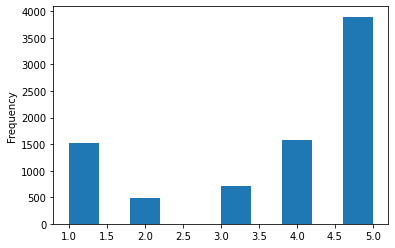

In [134]:
task2['rating'].plot(kind='hist')

Классы несбалансированны

In [118]:
task2['review'] = [lemmatize(row) for row in task2['review']]

In [121]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word')
bow_vectorizer = CountVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(task2['review'])
X_bow = bow_vectorizer.fit_transform(task2['review'])
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, task2['rating'], test_size=0.70, random_state=42)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, task2['rating'], test_size=0.70, random_state=42)

In [124]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from numpy import mean
from numpy import std
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_tfidf, y_train_tfidf, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.574 (0.018)


In [125]:
n_scores = cross_val_score(model, X_train_bow, y_train_bow, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.576 (0.020)


In [138]:
model = model.fit(X_train_tfidf, y_train_tfidf)
answers = model.predict(X_test_tfidf)

In [142]:
from sklearn.metrics import f1_score
y_true = y_test_tfidf
y_pred = answers
f1_score(y_true, y_pred, average='micro')

0.5926442391493812

Ф-мера средне

In [143]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

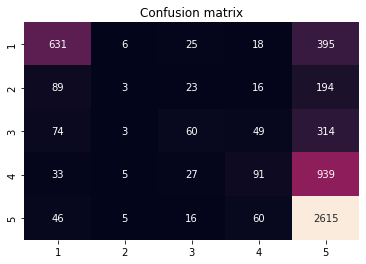

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, fmt="d", cbar=False, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Confusion matrix")
plt.show()

Почти все определяет как отзыв с оценкой 5, но умеет отделять 1 (в 60% случаев)

In [159]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_tfidf, y_train_tfidf)

answers = neigh.predict(X_test_tfidf)

In [160]:
y_true = y_test_tfidf
y_pred = answers
f1_score(y_true, y_pred, average='micro')

0.45319853582011504

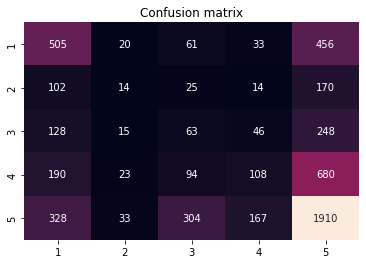

In [161]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, fmt="d", cbar=False, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Confusion matrix")
plt.show()

Логистическая регрессия лучше определяла, все так же путаются все классы с классом оценок на 5.0

In [164]:
clf = RandomForestClassifier(max_depth=2, random_state=42)
clf.fit(X_train_tfidf, y_train_tfidf)

answers = clf.predict(X_test_tfidf)
y_true = y_test_tfidf
y_pred = answers
f1_score(y_true, y_pred, average='micro')

0.4779501481610598

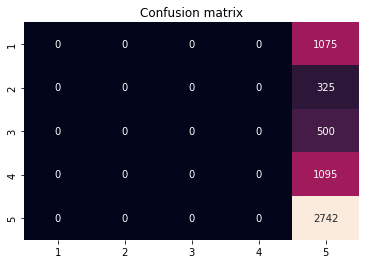

In [165]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, fmt="d", cbar=False, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Confusion matrix")
plt.show()

Рандомфорест вообще не справился, все приписал к 5ому классу

Градиентный бустинг

In [173]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=42).fit(X_train_tfidf, y_train_tfidf)
answers = clf.predict(X_test_tfidf)

In [174]:
y_true = y_test_tfidf
y_pred = answers
f1_score(y_true, y_pred, average='micro')

0.5569112776712567

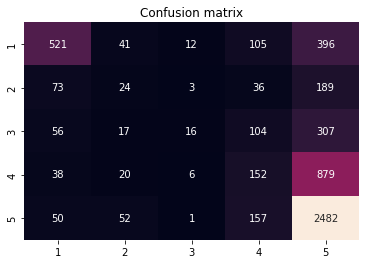

In [175]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, fmt="d", cbar=False, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Confusion matrix")
plt.show()

Градиентный бустинг почти на уровне логистической регрессии

##### Гридсерч

Логрег и градиентный бустинг

In [181]:
from sklearn.pipeline import Pipeline

logregpipe = Pipeline([('scale', StandardScaler(with_mean=False)),
                   ('logreg',LogisticRegression(multi_class="multinomial",solver="lbfgs"))])

# Gridsearch to determine the value of C
param_grid = {'logreg__C':np.arange(0.01,100,10)}
logreg_cv = GridSearchCV(logregpipe,param_grid,cv=5,return_train_score=True)
logreg_cv.fit(X_train_tfidf,y_train_tfidf)
print(logreg_cv.best_params_)

bestlogreg = logreg_cv.best_estimator_
bestlogreg.fit(X_train_tfidf,y_train_tfidf)
bestlogreg.coef_ = bestlogreg.named_steps['logreg'].coef_
bestlogreg.score(X_train_tfidf,y_train_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'logreg__C': 0.01}


0.7778681855166802

In [183]:
answers = bestlogreg.predict(X_test_tfidf)
y_true = y_test_tfidf
y_pred = answers
f1_score(y_true, y_pred, average='micro')

0.5694613909708907

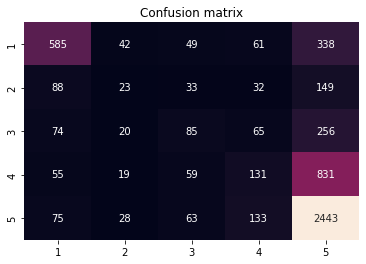

In [184]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, fmt="d", cbar=False, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Confusion matrix")
plt.show()

Ф-мера чуть меньше, чем у обычной логрег без подачи параметров...

Для градиентного бустинга

In [185]:
parameters = {
    "learning_rate": [0.01, 0.1, 2.0],
    "n_estimators":[200, 300]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

clf.fit(X_train_tfidf, y_train_tfidf)
print(clf.score(X_train_tfidf, y_train_tfidf))
print(clf.best_params_)

0.8112286411716843
{'learning_rate': 0.1, 'n_estimators': 300}


In [186]:
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, random_state=42).fit(X_train_tfidf, y_train_tfidf)
answers = clf.predict(X_test_tfidf)
y_true = y_test_tfidf
y_pred = answers
f1_score(y_true, y_pred, average='micro')

0.5769565975248387

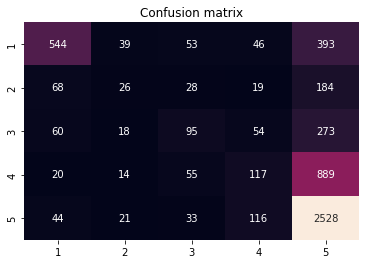

In [187]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, fmt="d", cbar=False, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Confusion matrix")
plt.show()

Вывод: все равно лучше всего справилась обычная логистическая регрессия без параметров, но градиентному бустингу помог подбор параметров по гридсерчу

Все равно лучше всего выделяются отзывы на 5, еще выделяются отзывы на 1. Видимо, все, кроме отзывов на 1, примерно одинаковые по сентимент анализу, и их сложно отделить простыми методами. (когда пишут worst, понятно, что все плохо, а когда описывают какие-то проблемы, нужно что-то более мудрое, чем bow или tfidf vectorizer)